In [65]:
### WIP



In [66]:
# https://github.com/SeldonIO/alibi-detect#drift-detection

In [67]:
# !pip install alibi-detect
# !pip install tensorflow
!pip install category_encoders

## Load the required library

In [1]:
import pandas as pd
import numpy as np

import category_encoders as ce
import joblib

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import joblib


## Read the input data

In [69]:
data = pd.read_csv('../../data/data.csv')

# cd = MMDDrift(x_ref, backend='tensorflow', p_val=.05)
# preds = cd.predict(x)

### Track the value of various features by printing the the head of dataset

In [70]:
data.head(5)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,148,Male,0,No,No,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,45.65,45.65,Yes
1,463,Male,0,Yes,Yes,4,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,101.15,385.90,Yes
2,471,Female,1,No,No,17,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.65,330.60,No
3,496,Male,0,No,No,22,No,No phone service,DSL,No,...,Yes,No,No,Yes,One year,Yes,Bank transfer (automatic),43.75,903.60,Yes
4,833,Female,0,Yes,Yes,70,Yes,No,DSL,Yes,...,Yes,Yes,No,Yes,One year,No,Credit card (automatic),74.10,5222.30,No


## Simple feature engineering
At first we raplaced the nan values with mean value.


In [71]:
# do all data massaging
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

data.replace(" ", np.nan, inplace=True)

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

mean = data['TotalCharges'].mean()
data.fillna(mean, inplace=True)



Convert the categorical features to the numeric features by one hot encoding and ordinal encoding.

We used the ordinal encoding for the features which their value has some order relationship to each other!


In [72]:
# Convert binary variable into numeric so plotting is easier. We need to later take mean

names = [ 'Partner', 'Dependents', 'PhoneService', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
# for column in names:
#     labelencoder(column)
data_enc = data
data_enc = data_enc.drop(['Churn', 'customerID'], axis=1)
enc = ce.ordinal.OrdinalEncoder(cols=names)
enc.fit(data_enc)
labelled_set = enc.transform(data_enc)
joblib.dump(enc, 'CustomerChurnOrdinalEncoder.pkl')


/Users/skasmani/opt/anaconda3/envs/AI_ML_38/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


['CustomerChurnOrdinalEncoder.pkl']


On the other hand, for the value that ther is not any ordinal relationship, we utilized one hot encoding.We also dropped the Churn and customerID.

In [73]:


names = ['gender','MultipleLines', 'InternetService', 'Contract', 'PaymentMethod', 'OnlineSecurity', 'OnlineBackup',
         'DeviceProtection', 'TechSupport']

ohe = ce.OneHotEncoder(cols=names)
data_ohe = data
data_ohe = data_ohe.drop(['Churn', 'customerID'], axis=1)
ohe.fit(data_ohe)
final_set = ohe.transform(labelled_set)
joblib.dump(ohe, 'CustomerChurnOneHotEncoder.pkl')


['CustomerChurnOneHotEncoder.pkl']

Print the head of modified data

In [74]:
final_set.head(5)

,gender_1,gender_2,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_1,MultipleLines_2,MultipleLines_3,...,Contract_1,Contract_2,Contract_3,PaperlessBilling,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,MonthlyCharges,TotalCharges
0,1,0,0,1,1,1,1,1,0,0,...,1,0,0,1,1,0,0,0,45.65,45.65
1,1,0,0,2,2,4,1,0,1,0,...,1,0,0,2,1,0,0,0,101.15,385.90
2,0,1,1,1,1,17,1,1,0,0,...,0,1,0,2,0,1,0,0,20.65,330.60
3,1,0,0,1,1,22,2,0,0,1,...,0,1,0,1,0,0,1,0,43.75,903.60
4,0,1,0,2,2,70,1,1,0,0,...,0,1,0,2,0,0,0,1,74.10,5222.30


If you want you can split your data to two parts and then use the training for defining outlier detection, and test data for testing  the model.

However, we know just use the whole data for outlier detection to see how various model works on this churn data.

In [75]:
from sklearn.model_selection import train_test_split
labels = data['Churn']
to_model_columns=final_set.columns
X_train, X_test, y_train, y_test = train_test_split(final_set, labels, test_size=0.2)
print ('Training Data Shape',X_train.shape, y_train.shape)
print ('Testing Data Shape',X_test.shape, y_test.shape)

Y = data['Churn']
X = final_set


Training Data Shape (5634, 37) (5634,)
Testing Data Shape (1409, 37) (1409,)


In [76]:
print(X_train.shape[1])


print(X_train.shape)

37
(5634, 37)


In [77]:
from alibi_detect.od import IForest
od = IForest(threshold=0.01, n_estimators=500)

od.fit(X.values)

In [78]:
# od_preds = od.predict(X_test, return_instance_score=True)
# print(od_preds)
#
#col #34 is the monthly bill amount
input_with_insane_monthly_charges = X_test.iloc[0]
# input_with_insane_monthly_charges.values[34] = 22975.0
# input_with_insane_monthly_charges.values[35] = 25000.0
print(input_with_insane_monthly_charges.values.reshape(1,37))

od_preds = od.predict(input_with_insane_monthly_charges.values.reshape(1,37), return_instance_score=True)
print(od_preds)

[[0.00000e+00 1.00000e+00 1.00000e+00 2.00000e+00 2.00000e+00 3.20000e+01
  1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00
  0.00000e+00 2.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 9.13500e+01
  2.89655e+03]]
{'data': {'instance_score': array([0.05420877]), 'feature_score': None, 'is_outlier': array([1])}, 'meta': {'name': 'IForest', 'detector_type': 'offline', 'data_type': 'tabular'}}


In [79]:
print(od_preds)

{'data': {'instance_score': array([0.05420877]), 'feature_score': None, 'is_outlier': array([1])}, 'meta': {'name': 'IForest', 'detector_type': 'offline', 'data_type': 'tabular'}}


In [80]:
od_preds = od.predict(X.values, return_instance_score=True)
# od_preds["is_outlier"]
# od_preds.values()[2].keys()[0]
pred_list = list(od_preds.values())
pred_list = pred_list[0]['is_outlier']
outlier_index = np.where(pred_list==0)
len(outlier_index[0])

1421

In [81]:
joblib.dump(final_set.columns, 'CustomerChurnFeaturesColumns.pkl')

final_set.columns

Index(['gender_1', 'gender_2', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines_1', 'MultipleLines_2',
       'MultipleLines_3', 'InternetService_1', 'InternetService_2',
       'InternetService_3', 'OnlineSecurity_1', 'OnlineSecurity_2',
       'OnlineSecurity_3', 'OnlineBackup_1', 'OnlineBackup_2',
       'OnlineBackup_3', 'DeviceProtection_1', 'DeviceProtection_2',
       'DeviceProtection_3', 'TechSupport_1', 'TechSupport_2', 'TechSupport_3',
       'StreamingTV', 'StreamingMovies', 'Contract_1', 'Contract_2',
       'Contract_3', 'PaperlessBilling', 'PaymentMethod_1', 'PaymentMethod_2',
       'PaymentMethod_3', 'PaymentMethod_4', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

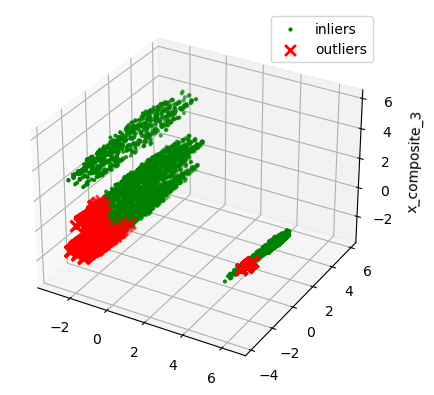

In [82]:



pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X3 = scaler.fit_transform(X[to_model_columns])
X_reduce = pca.fit_transform(X3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

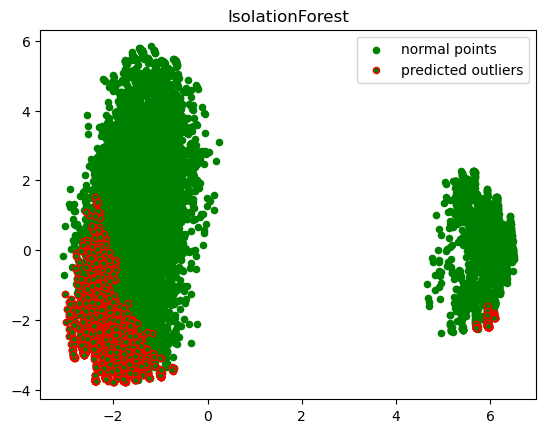

In [83]:
pca = PCA(n_components=2)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X2 = scaler.fit_transform(X[to_model_columns])
X_reduce = pca.fit_transform(X2)

outlier_index = outlier_index[0]

res=pd.DataFrame(X_reduce)
Z = np.array(res)
plt.title("IsolationForest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [84]:
# from tensorflow.keras.models import Sequential
# from alibi_detect.models.losses import elbo

from tensorflow.keras.layers import Dense, InputLayer, Input
import tensorflow as tf


n_features = X.shape[1]
latent_dim=10

encoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(n_features, ), name="encode1"),
        Dense(64, activation=tf.nn.relu,  name="encode2"),
        Dense(32, activation=tf.nn.relu,  name="encode3"),
        Dense(latent_dim, activation=tf.nn.relu, name="encode4")
    ])


decoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(latent_dim,), name="decode1"),
        Dense(32, activation=tf.nn.relu, name="decode2"),
        Dense(64, activation=tf.nn.relu, name="decode3"),
        Dense(n_features, activation=None, name="decode4")
    ])

In [85]:
from alibi_detect.od import OutlierVAE, OutlierAE

outlier_predictor = OutlierAE(
    threshold=0.11,
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    data_type="tabular"
)

## Todo checl with VAE too
# outlier_predictor = OutlierVAE(
#     threshold=0.05,
#     score_type="mse",
#     encoder_net=encoder_net,
#     decoder_net=decoder_net,
#     latent_dim=latent_dim,
#     samples=20
# )

In [86]:
outlier_predictor.fit(X.values, epochs=100, batch_size=240, verbose=False)
outlier_predictor

OutlierAE

In [87]:
input_with_insane_monthly_charges = X_test.iloc[0]
input_with_insane_monthly_charges.values[34] = 22975.0
input_with_insane_monthly_charges.values[35] = 125000.0


preds = outlier_predictor.predict(np.reshape(input_with_insane_monthly_charges.values, (-1, 37)), outlier_perc=25,outlier_type='instance',
                                   return_feature_score=True,  return_instance_score=True)
print(preds)


{'data': {'instance_score': array([8.98293357e+08]), 'feature_score': array([[2.12606551e+06, 9.99776229e+04, 9.53696688e+06, 4.66527411e+06,
        5.26720930e+07, 1.57326163e+08, 5.72192913e+06, 4.71932346e+06,
        5.39077361e+06, 5.03367472e+05, 2.70715342e+07, 9.12903441e+06,
        1.56048832e+06, 3.20520529e+05, 6.49940253e+07, 2.94732298e+07,
        1.18701059e+07, 8.23756018e+07, 2.32113055e+05, 2.25413881e+03,
        1.71005712e+07, 2.95090956e+06, 5.94287860e+06, 2.89507816e+06,
        7.48897609e+06, 7.90173061e+06, 2.69014736e+06, 3.15705832e+06,
        5.35198426e+05, 2.73157611e+06, 7.17082314e+07, 1.53346181e+07,
        7.80108675e+05, 1.34914293e+06, 5.90440998e+08, 7.24994330e+08,
        7.18187737e+09]]), 'is_outlier': array([1])}, 'meta': {'name': 'OutlierAE', 'detector_type': 'offline', 'data_type': 'tabular'}}


In [88]:



od_preds = outlier_predictor.predict(X.values, outlier_type='instance',
                                   return_feature_score=False,  return_instance_score=False)
# 
# od_preds = od.predict(X_train.values, return_instance_score=True)
# od_preds["is_outlier"]
# od_preds.values()[2].keys()[0]
pred_list = list(od_preds.values())
pred_list = pred_list[0]['is_outlier']
pred_list
outlier_index = np.where(pred_list==0)

In [89]:
len(outlier_index[0])

116

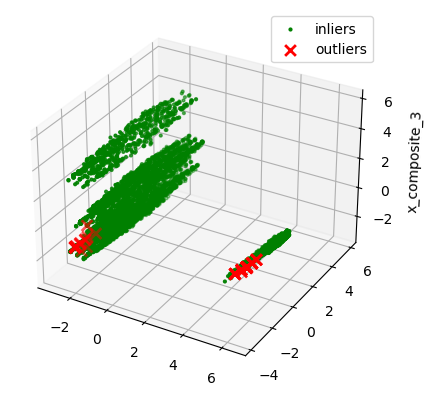

In [90]:

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X1 = scaler.fit_transform(X[to_model_columns])
X_reduce = pca.fit_transform(X1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

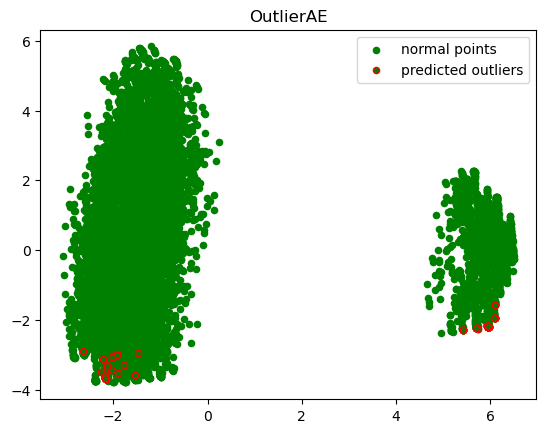

In [91]:
pca = PCA(n_components=2)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X2 = scaler.fit_transform(X[to_model_columns])
X_reduce = pca.fit_transform(X2)

outlier_index = outlier_index[0]


res=pd.DataFrame(X_reduce)
Z = np.array(res)
plt.title("OutlierAE")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [92]:
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(X[to_model_columns])
pred = clf.predict(X[to_model_columns])
final_set['anomaly']=pred
outliers=X.loc[final_set['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(final_set['anomaly'].value_counts())
joblib.dump(clf, 'CustomerChurnOutlierPredictor.sav')

 1    6197
-1     846
Name: anomaly, dtype: int64


['CustomerChurnOutlierPredictor.sav']

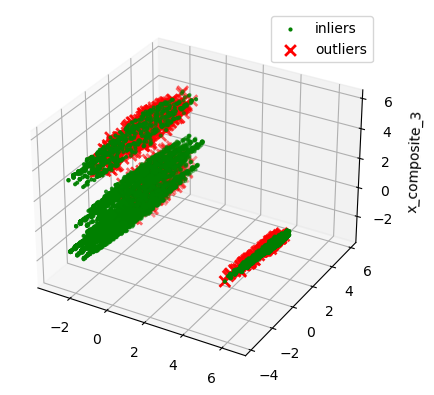

In [93]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X2 = scaler.fit_transform(X[to_model_columns])
X_reduce = pca.fit_transform(X2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

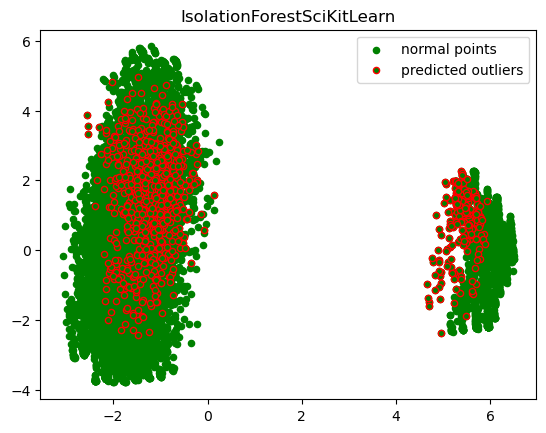

In [94]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X2 = scaler.fit_transform(X[to_model_columns])
X_reduce = pca.fit_transform(X2)



res=pd.DataFrame(X_reduce)
Z = np.array(res)
plt.title("IsolationForestSciKitLearn")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()